# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>

### <font color="red">Exercise 03.1: European option pricing<font>

In this notebook we will try to compute via Monte Carlo the price of European options, both in the call and in the put cases. We will study only the European ones because it's one of the few cases that have been analitically solved, so we can confront our Monte Carlo solution with the exact price of the options estabilished by a formula.

### Analytic solution: Black-Scholes theory

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion with constant risk-free interest rate $r$ and volatility $\sigma$.

The following is Black-Scholes analytic solution for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$

### Parameters setting

We are using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

Our goal is to compute via Monte Carlo at time $t=0$ the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$; so we'll estabilish which price should be paid now for the call-option and put-option that expires at $T=1$.

### Exact solution

We'll keep the exact solution's results to confront them with ours.

In [1]:
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt

# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


### Monte Carlo method

We'll compute the price in two different ways and verify both give the same results. First the price will be obtained by sampling **directly** the final asset price $S(T)$ for a geometric brownian motion $GBM(r,\sigma^2)$; then by sampling the discretized $GBM(r,\sigma^2)$ path of the asset price **dividing** $[0,T]$ in $100$ intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$.

In the direct case, for calculating the price $S(t)$ we'll use the following formula, knowing $W(t)\sim\mathcal{N}(0,t)$:

$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$

While in the discrete one, we'll exploit the following recursion, with $Z_i \sim \mathcal{N}(0,1)$:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$

The two ways must not differ since the simulation method for brownian motion is exact, in the sense that the joint distribution of the simulated values coincides with the joint distribution of the continuous-time process at the discrete time of the simulation.

The idea behind our approach is to perform many times the simulation of the asset prices and extimate their value at the expiring times, then establish the option-pricing at t=0 by multiplying by $e^{-\mu T}$.

As usual, we simulate $10^5$ asset's prices and divide the results in $100$ blocks to calculate uncertainty throughout the all process of extraction.

Our results are compatible in all cases with the theoretical predictions.

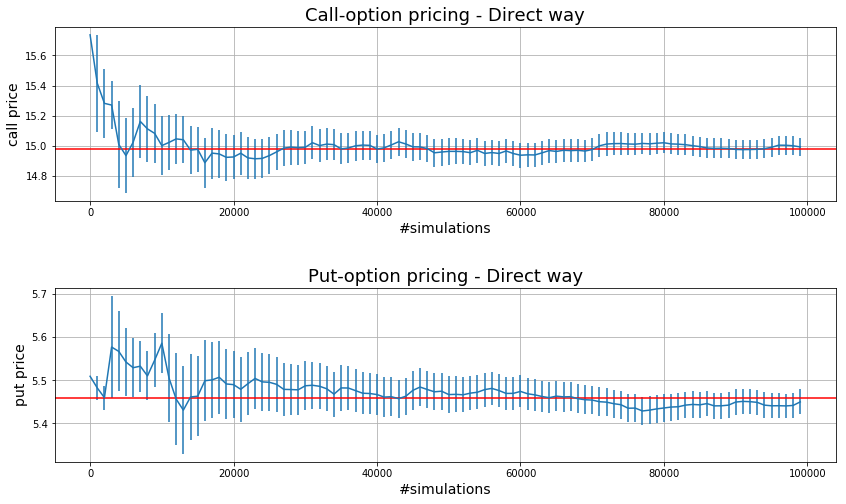

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

M=100000              # Total number of throws
N=100                 # Number of blocks
L=int(M/N)            # Number of throws in each block, please use for M a multiple of N

x = np.arange(N)      # [0,1,2,...,N-1]

call_prog, call_err = np.loadtxt("./3.1/Prima_parte/risultati_call.dat", usecols=(0,1), delimiter=' ', unpack='true')    
put_prog, put_err = np.loadtxt("./3.1/Prima_parte/risultati_put.dat", usecols=(0,1), delimiter=' ', unpack='true')    


x*=L # Number of throws = block * (Number of throws in each block)

fig=plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.)

plt.subplot(2, 1, 1)
plt.errorbar(x,call_prog,yerr=call_err)
plt.title('Call-option pricing - Direct way', fontsize=18)
plt.axhline(y=call, color='r', linestyle='-')
plt.xlabel('#simulations', fontsize=14)
plt.ylabel('call price', fontsize=14)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.errorbar(x,put_prog,yerr=put_err)
plt.title('Put-option pricing - Direct way', fontsize=18)
plt.axhline(y=put, color='r', linestyle='-')
plt.xlabel('#simulations', fontsize=14)
plt.ylabel('put price', fontsize=14)
plt.grid(True)


plt.show()

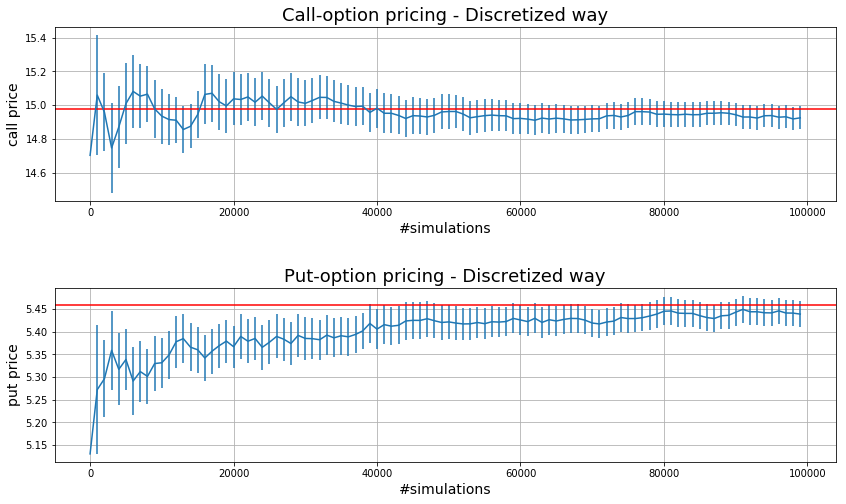

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

M=100000              # Total number of throws
N=100                 # Number of blocks
L=int(M/N)            # Number of throws in each block, please use for M a multiple of N

x = np.arange(N)      # [0,1,2,...,N-1]

call_prog, call_err = np.loadtxt("./3.1/Seconda_parte/risultati_call.dat", usecols=(0,1), delimiter=' ', unpack='true')    
put_prog, put_err = np.loadtxt("./3.1/Seconda_parte/risultati_put.dat", usecols=(0,1), delimiter=' ', unpack='true')    


x*=L # Number of throws = block * (Number of throws in each block)

fig=plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.)

plt.subplot(2, 1, 1)
plt.errorbar(x,call_prog,yerr=call_err)
plt.title('Call-option pricing - Discretized way', fontsize=18)
plt.axhline(y=call, color='r', linestyle='-')
plt.xlabel('#simulations', fontsize=14)
plt.ylabel('call price', fontsize=14)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.errorbar(x,put_prog,yerr=put_err)
plt.title('Put-option pricing - Discretized way', fontsize=18)
plt.axhline(y=put, color='r', linestyle='-')
plt.xlabel('#simulations', fontsize=14)
plt.ylabel('put price', fontsize=14)
plt.grid(True)

plt.show()